Este archivo lo que hace es generar información rápida sobre toda la
simulación.

Se grafican la evolución de las variables de una simulación en un punto
en conjunto con la evolución de la densidad de energía.


In [1]:
# Librerías a usar
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy.polynomial.polynomial as poly
import matplotlib
import matplotlib.patches as mpatches
import math

In [2]:
# Path de los archivos que quiero abrir
path = '/run/media/cecere/7d4a4576-37a1-4a7a-bcab-27905bc96ce8/Backup_femputadora/data_loop/'
simulacion ='desequilibrio_3'

In [68]:
# Tomo el primer dato para ver que contiene el archivo
g = h5py.File(path+simulacion+'/'+'welbalanced_hdf5_plt_cnt_0000','r')
g.keys() # para ver toda la información que contiene el archivo

ncx1b  = list(g['integer scalars'][0])[1]     # Número de celdas en un bloque en x
#print(ncx1b)
ncy1b  = list(g['integer scalars'][1])[1]     # Número de celdas en un bloque en y
#print(ncy1b)
boundb = g['bounding box'][:,:,:]           # Coordenada central de cada bloque
#print(boundb)
    
niprocs = list(g['integer scalars'][7])[1]     # Número de procesadores usados en x = número de bloques en x
#print(niprocs)
njprocs = list(g['integer scalars'][8])[1]     # Número de procesadores usados en y = número de bloques en y
#print(njprocs)
    
#print(list(f['integer scalars']))
#0 -> nxb 50
#1 -> nyb 50
#2 -> nzb 1
#3 -> dimensionality 2
#4 -> globalnumblocks 49
#5 -> nstep 1
#6 -> nbegin 1
#7 -> iprocs 7
#8 -> jprocs 7
#9 -> kprocs 1
#10 -> splitnumblocks 0 
#11 -> splitnumparticles 0
#12 -> checkpointfilenumber 1
#13 -> plotfilenumber 0
#14 -> forcedplotfilenumber 0
    
nb = list(g['integer scalars'][4])[1]   # Número total de bloques iprocs x jprocs
#print(nb)
# Número total de celdas en "x" y en "y"
ncx = niprocs*ncx1b
ncy = njprocs*ncy1b

In [69]:
# Da las coordenadas del centro de los bloques
#print(list(g['coordinates']))

# Da las 3 coordenadas del centro del bloque 0 (hay 49 elementos)
#print(list(g['coordinates'][0]))

# Da las coordenadas x, y, z del centro del bloque 0 (hay 49 elementos)
# g['coordinates'][bloque][coordenada]
#print(g['coordinates'][0][0])
#print(g['coordinates'][0][1])
#print(g['coordinates'][0][2])

# Defino deltaxb: coordenada x ([0]) del segundo bloque en x [1] menos el primer bloque [0].
deltaxb = np.abs(list(g['coordinates'][1])[0]-list(g['coordinates'][0])[0])
#print(deltaxb)

# Defino deltax: deltaxb entre los centros de los primeros 2 bloques / número de celdas en 1 bloque
deltax = deltaxb/ncx1b
#print(deltax)

# Defino deltayb: coordenada y ([1]) del segundo bloque en y [niprocs] menos el primer bloque [0].
deltayb = np.abs(list(g['coordinates'][niprocs])[1]-list(g['coordinates'][0])[1])
#print(deltayb)

# Defino deltay: deltayb entre los centros de los primeros 2 bloques / número de celdas en 1 bloque
deltay = deltayb/ncy1b
#print(deltay)

# Defino xmin = valor en x del centro del bloque cero - 1/2 del deltax de 1 bloque
xmin = list(g['coordinates'][0])[0] - 0.5*deltaxb
#print(xmin)

# Defino xmax = valor en x del centro del bloque niprocs-1 + 1/2 del deltax de 1 bloque
xmax = list(g['coordinates'][niprocs-1])[0] + 0.5*deltaxb
#print(xmax)

# Ojo, puede haber problemas por la precision
#print(type(list(g['coordinates'][niprocs-1])[0]))
#print(type(0.5*deltaxb))
# Se cambia la precisión así:
#dummy = g['coordinates'][niprocs-1][0]
#dummy = dummy.astype('float64')
#print(type(dummy))

# Defino ymin = valor en y del centro del bloque cero - 1/2 del deltay de 1 bloque
ymin = list(g['coordinates'][0])[1] - 0.5*deltayb
#print(ymin)

# Defino ymax = valor en y del centro del bloque (niprocs-1)*njprocs + 1/2 del deltay de 1 bloque
ymax = list(g['coordinates'][(niprocs-1)*njprocs])[1] + 0.5*deltayb
#print(ymax)

In [70]:
# Quiero elegir un slice, y graficar la propiedad en el tiempo
# Doy el punto en coordenadas físicas:
# slice en x
ym = 2e9
# Encuentro el bloque en y:
iby = int(ym*njprocs/(ymax-ymin))
print(iby)
# Calculo el indice en y dado el bloque
iy = int((ym-iby*(ymax-ymin)/njprocs)*njprocs/(ymax-ymin)*ncy1b)
print(iy)

## slice en y
#xm = 0.1e9
## Encuentro el bloque en x:
#ibx = int(xm*niprocs/(xmax-xmin))
##print(ibx)
## Calculo el indice en x dado el bloque
#ix = int((xm-ibx*(xmax-xmin)/niprocs)*niprocs/(xmax-xmin)*ncx1b)
##print(ixb)

4
0


In [71]:
# Defino los índices de tiempo mínimo y máximo
itmin = 0
itmax = 99
# Defino el tiempo físico
time=np.arange(itmin, itmax+1)*0.5 # 1 plot cada 0.5 segundos
#print(len(time))

pdens = np.zeros((len(time),ncx))
#pmagx = np.zeros((len(time),ncx))
#print(pdens)
for i in range(itmin,itmax+1):
#    print('i=',i)
    if   i < 10 :       # Poner el path que corresponda
        f = h5py.File(path+simulacion+'/'+'welbalanced_hdf5_plt_cnt_000'+str(i),'r')
    elif i < 100 :
        f = h5py.File(path+simulacion+'/'+'welbalanced_hdf5_plt_cnt_00'+str(i),'r')
    elif i < 1000 :
        f = h5py.File(path+simulacion+'/'+'welbalanced_hdf5_plt_cnt_0'+str(i),'r')
    else :
        f = h5py.File(path+simulacion+'/'+'welbalanced_hdf5_plt_cnt_'+str(i),'r')
#    print(f)


    # Construyo la matriz con los bloques de los datos
    # El orden debe ser (y,x)

    for ibx in range(niprocs):
        for ix in range(ncx1b):
            pdens[i,ibx*ncx1b+ix]=f['dens'][ibx+iby*niprocs,0,iy,ix]
            #pmagx[i,ibx*ncx1b+ix]=f['magx'][ibx+iby*niprocs,0,iy,ix]


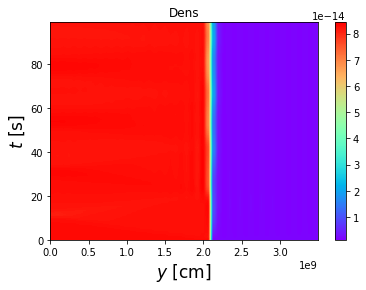

In [72]:
rango=(xmin,xmax,itmin,itmax)
plt.imshow(pdens[:,0:50],cmap='rainbow', extent=rango,origin='lower',aspect='auto')
plt.title('Dens')
plt.ylabel(r'${t}$ [s]',fontsize=17)  
plt.xlabel(r'${y}$ [cm]',fontsize=17)
plt.colorbar()
plt.show()

In [33]:
print(iby)

3
